In [13]:
import numpy as np
import matplotlib.pyplot as plt

import numdifftools as nd
from scipy.interpolate import interp1d

In [14]:
import modules.plots.deconvolution as dec_plots
import modules.experiment.rir as exprir
from modules import randomized_ir, utils, mcmc, adc

from modules_reloader import reloader
relmod = reloader(dec_plots, exprir, randomized_ir, utils, mcmc, adc)

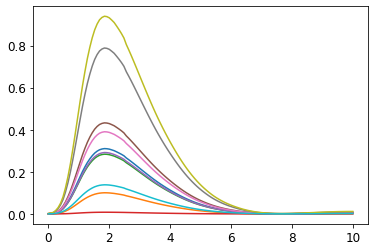

In [15]:
ir_t, ir_shape = exprir.read_ir_shape()
ir_t, ir_shape = exprir.cut_ir_shape(ir_t, ir_shape, excluded_integral_percentile=0.02)

rir = randomized_ir.RandomizedIr(ir_x=ir_t, ir_y=ir_shape, factor=exprir.generate_C_pmt)
L = rir.L

rir.plot_realizations()

In [16]:
N = 35

n_vec_lambda = 20
n_vec = utils.generate_poissonian_ns(n_vec_lambda, N)

# injecting fake signal in 3 central bins
n_vec[ N//2-1 : N//2+2  ] += 2*n_vec_lambda

adc_step = 2.0

s_vec = adc.adc_accepted_s_vec(rir.convolve_with_n_vec(n_vec), adc_step)

In [17]:
rireff = randomized_ir.RandomizedIrEffect(rir, N, samplesize=10**6)

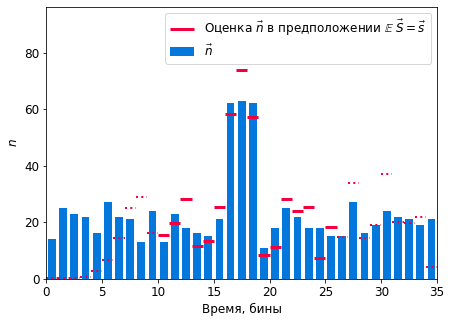

In [19]:
n_vec_estimation = rireff.estimate_n_vec(s_vec, delta=adc_step)
f, a = dec_plots.plot_mean_n_estimation(n_vec, n_vec_estimation, L)

# TEMP

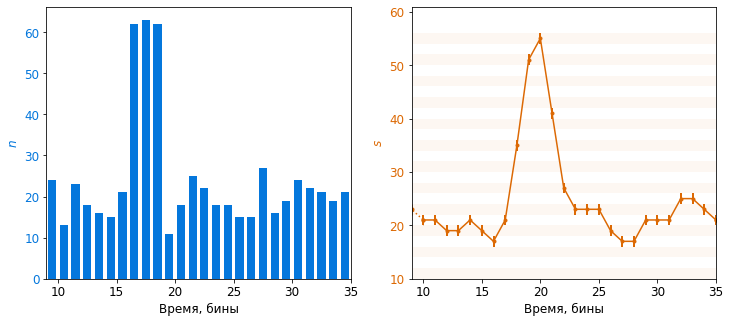

In [48]:
from modules.plots._shared import Color, Figsize, TIME_LABEL

delta = adc_step
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

ax1.bar(np.arange(N) + 0.5, n_vec, width=0.7, color=Color.N.value)
ax1.set_xlabel(TIME_LABEL)
ax2.set_xlabel(TIME_LABEL)
ax1.set_ylabel('$n$', color=Color.N.value)
ax1.tick_params(axis='y', labelcolor=Color.N.value)

if delta is not None:
    for i in range(5, int(s_vec.max() / delta) + 2):
        ax2.axhspan(
            delta * i,
            delta * (i + 1),
            facecolor=([1, 1, 1, 0] if i % 2 == 0 else [*Color.S.as_rgb(), 1]),
            alpha=0.05,
            edgecolor=None,
        )

t_S = np.arange(1, N + L + 1)

def plot_signal_part(start, end, dashed):
    if delta is None:
        ax2.plot(t_S[start:end], s_vec[start:end], ('.-' if not dashed else '.:'), color=Color.S.value)
    else:
        ax2.errorbar(
            t_S[start:end],
            s_vec[start:end] + delta / 2,
            yerr=delta / 2,
            fmt=('.-' if not dashed else '.:'),
            elinewidth=(2 if not dashed else 0.5),
            color=Color.S.value,
        )

plot_signal_part(0, L + 1, dashed=True)  # t in [1, L] with +1 point to the right (connection)
plot_signal_part(L, N, dashed=False)  # t in [L+1, N]
plot_signal_part(N - 1, N + L, dashed=True)  # t in [N+1, N+L] with +1 point to the left (connection)

ax2.set_ylabel('$s$', color=Color.S.value)
ax2.tick_params(axis='y', labelcolor=Color.S.value)

ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=10)
ax1.set_xlim(L, N)
ax2.set_xlim(L, N)

fig.savefig('../presentation/convolution-example.pdf')

# TEMP

In [20]:
ll_fact = rireff.get_loglikelihood_independent_normdist(s_vec, delta=adc_step, density=False)
ll_fact(n_vec_estimation)  # let the numba do the trick
ll_mvn_density = rireff.get_loglikelihood_mvn(s_vec, delta=adc_step, density=True)
ll_mvn = rireff.get_loglikelihood_mvn(s_vec, delta=adc_step, density=False)

In [21]:
for ll_timed in [utils.timer(lambda *a, **kw: '')(ll) for ll in (ll_fact, ll_mvn_density, ll_mvn)]:
    print(ll_timed(n_vec_estimation))

loglikelihood_normdist() took 7.937000191304833e-06 seconds to complete.
-22.307007304636404
loglikelihood_mvn() took 0.0007031099994492251 seconds to complete.
-26.255150695988046
loglikelihood_mvn() took 0.004295637998438906 seconds to complete.
-13.605426166515056


In [22]:
relmod()

In [23]:
result_preliminary = mcmc.run_mcmc(
    logposterior=ll_fact,
    init_point=n_vec_estimation,
    config=mcmc.SamplingConfig(
        n_walkers=128,
        n_samples=20000,
        progress_bar=True,
        # autocorr_estimation_each=3000,
        # debug_acceptance_fraction_each=500,
    ) 
)

100%|██████████| 20000/20000 [00:14<00:00, 1402.48it/s]


In [24]:
tau = result_preliminary.sampler.get_autocorr_time(quiet=True).mean()

N/50 = 400;
tau: [2372.44452059 2426.90549794 2454.61872117 2363.23647593 1827.15640949
 1671.29416593 1564.60558191 1823.34288387 1744.38746184 1699.01132354
 1598.53109577 1532.23868782 1474.82838939 1495.11504302 1503.86125014
 1455.94853172 1465.90596813 1442.67976797 1466.71269752 1566.94806187
 1598.23438212 1422.45826946 1435.11337248 1400.7870561  1440.60053141
 1561.80698366 1491.36754057 1493.47357393 1521.71761265 1528.82963266
 1411.68515661 1406.47239176 1473.72630857 1753.6295221  1956.31336737]


In [25]:
n_walkers_final = 128

init_pts = mcmc.extract_independent_sample(result_preliminary.sampler, desired_sample_size=n_walkers_final)

In [27]:
result = mcmc.run_mcmc(
    logposterior=ll_mvn,
    init_point=init_pts,
    config=mcmc.SamplingConfig(
        n_walkers=n_walkers_final,
        n_samples=4 * tau,
        progress_bar=True,
        starting_points_strategy='given',
    )
)

100%|██████████| 6610/6610 [15:22<00:00,  7.17it/s]


In [28]:
sample_preliminary = mcmc.extract_independent_sample(result_preliminary.sampler, tau_override=tau, debug=True)
sample = mcmc.extract_independent_sample(result.sampler, tau_override=tau, debug=True)

Autocorrelation time is estimated at 1652.7425210572108 (ranges from 1652.74252105721 to 1652.74252105721)
Burn-in = 3305 samples
Thinning = 1487 samples
Resulting sample size = 1408
Autocorrelation time is estimated at 1652.7425210572108 (ranges from 1652.74252105721 to 1652.74252105721)
Burn-in = 3305 samples
Thinning = 1487 samples
Resulting sample size = 256


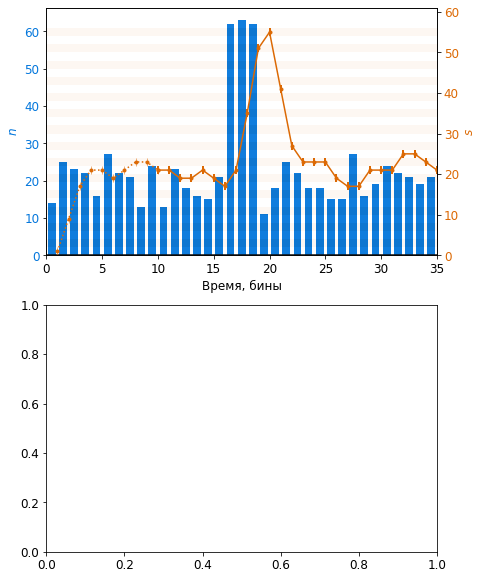

/home/njvh/Documents/Science/sphere/thesis/modules/plots/deconvolution.py:260: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(
<ipython-input-29-a008762f3b92>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_conv_solution.show()


In [29]:
fig_conv_solution, (ax_conv, ax_solution) = plt.subplots(nrows=2, figsize=dec_plots.Figsize.TWOPANEL_VERT.value)

dec_plots.plot_convolution(
    n_vec=n_vec, s_vec=s_vec, delta=adc_step, fig_ax=(fig_conv_solution, ax_conv), end_x_axis_on_N=True,
)

dec_plots.plot_bayesian_mean_estimation(n_vec, sample, L, n_vec_estimation, fig_ax=(fig_conv_solution, ax_solution))

fig_conv_solution.savefig('../doc/pic/final-problem-and-solution.pdf')

fig_conv_solution.show()

# TEMP

<ipython-input-69-c9aca2d976c7>:36: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(


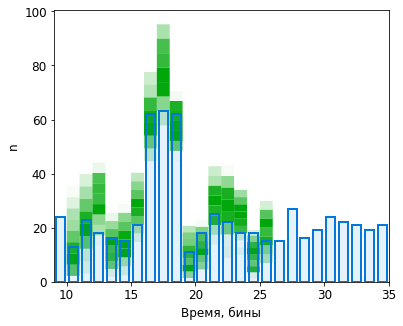

In [69]:
fig, ax = plt.subplots(figsize=(6, 5))

from matplotlib.colors import ListedColormap

t_offset = 0

N_BARS_ALPHA = 0.1
n_bars = ax.bar(
    bin_centers,
    n_vec,
    width=0.7,
    color=[*Color.N.as_rgb(), N_BARS_ALPHA],
    edgecolor=Color.N.value,
    linewidth=2,
    label='$\\vec{n}$',
)

inferred_color_rgb = Color.N_INFERRED.as_rgb()

bin_hists_cm = ListedColormap(
    colors=np.array(
        [[*inferred_color_rgb, alpha] for alpha in np.linspace(0, 1, 100)],
    ),
    name='N_estimation_alphamap',
)

bin_centers = np.arange(N) + 0.5 + t_offset

for i_bin, sample_in_bin in enumerate(sample.T):
    if i_bin <= L or i_bin >= N - L:
        continue
    hist_in_bin, n_value_bin_edges = np.histogram(sample_in_bin, bins=10, density=True)
    pcm_Y = 0.5 * (n_value_bin_edges[:-1] + n_value_bin_edges[1:])
    pcm_X = t_offset + np.array([i_bin, i_bin + 1])
    pcm_C = np.tile(hist_in_bin, (2, 1)).T
    ax.pcolormesh(
        pcm_X, pcm_Y, pcm_C, shading='flat', edgecolors=[(0, 0, 0, 0)], cmap=bin_hists_cm, antialiased=True
    )

ax.set_xlim(L, N-L)
ax.set_ylim(bottom=0)
ax.set_xlim(t_offset + L, t_offset + N)

ax.set_xlabel(TIME_LABEL)
ax.set_ylabel('n')

fig.savefig('../presentation/deconv-example.pdf')

# TEMP

(<Figure size 504x360 with 1 Axes>, <AxesSubplot:xlabel='$n_{17}$'>)

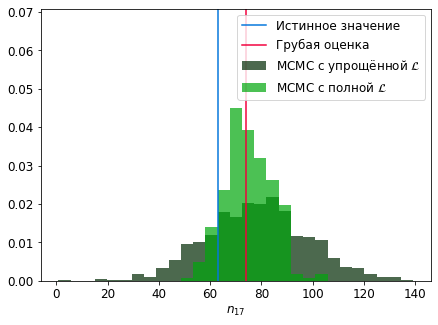

In [31]:
filename = 'simplified-and-true-likelihood-comparison'
# filename = None

dec_plots.plot_bayesian_mean_estimation_in_bin(
    n_vec,
    [sample_preliminary, sample],
    ['MCMC с упрощённой $\\mathcal{{L}}$', 'MCMC с полной $\\mathcal{{L}}$'],
    n_vec_estimation=n_vec_estimation,
    ibin=17,
    filename=filename
)